# GENERATING IMAGES USING VARIATIONAL AUTOENCODER

## Importing Packages

In [ ]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

2025-12-07 16:07:06.843549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 16:07:06.843840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 16:07:06.882813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 16:07:08.104366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
os.environ["TF_USE_LEGACY_KERAS"] = "1"     # For Keras 2.x compatibility in Keras 3.x installation

## Data Acquisition & Preparation

Uses Fashion MNIST data set containing 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. Pixel value of the images ranges from 0 through 255.

In [ ]:
# Loads the dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
# Values are normalized in range 0 — 1 by dividing each value by 255.

X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [5]:
# Separates validation set from full train set stratifically

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=10_000, random_state=42, stratify=y_train_full)

## Modeling

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer to sample the coding given mean vector (μ) and log variance vector (γ) 
    where γ = log(σ^2). σ is standard deviation vector.
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

**Modeling Variational Encoder**

In [ ]:
tf.random.set_seed(42)

codings_size = 10   # Length of the mean vector and log variance vector representing latent space of the input data. 

inputs = tf.keras.layers.Input(shape=[28, 28])              # Layer to accept 2D images
Z = tf.keras.layers.Flatten()(inputs)                       # Flattens the images
Z = tf.keras.layers.Dense(150, activation="relu")(Z)        # A dense layer with output units and "relu" activation function
Z = tf.keras.layers.Dense(100, activation="relu")(Z)        # A dense layer with output units and "relu" activation function
codings_mean = tf.keras.layers.Dense(codings_size)(Z)       # Coding layer for mean vector (μ)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)    # Coding layer for log variance vector (γ)
codings = Sampling()([codings_mean, codings_log_var])       # Sampling layer to sample random coding vector from Gaussian distribution with with mean μ and standard deviation σ

variational_encoder = tf.keras.Model(                       # Creates variation encoder by combining inputs and codings
    inputs=[inputs], 
    outputs=[codings_mean, codings_log_var, codings])

2025-12-07 16:07:48.360404: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Modeling Variational Decoder**

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])        # Input layer with shape equal to the size of the coding
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)   # Dense layer with 100 output units with "relu" activation
x = tf.keras.layers.Dense(150, activation="relu")(x)                # Dense layer with 150 output units with "relu" activation
x = tf.keras.layers.Dense(28 * 28)(x)                               # Dense layer with output units equal to number of pixels in an input image
outputs = tf.keras.layers.Reshape([28, 28])(x)                      # Reshape layer to reshape 1D input into 2D

variational_decoder = tf.keras.Model(               # Creates variational decoder by combining codings and outputs
    inputs=[decoder_inputs], outputs=[outputs])

**Combining Encoder & Decoder**

In [ ]:
_, _, codings = variational_encoder(inputs)     # Ignores first two outputs to feed only codings to the decoder
reconstructions = variational_decoder(codings)

variational_ae = tf.keras.Model(                # Creates variational autoencoder by combining inputs and outputs
    inputs=[inputs], outputs=[reconstructions])

In [ ]:
# Latent loss function to push the codings gradually migrate within the coding space
# (also called the latent space) to end up looking like a cloud of Gaussian points.
# It computes the latent loss for each instance in the batch, summing over the last axis.

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(
    tf.reduce_mean(latent_loss) / 784.  # Computes the mean loss over all the instances in the batch, 
                                        # followed by dividing the result by 784 to ensure it has the 
                                        # appropriate scale compared to the reconstruction loss.
    )

In [ ]:
# Compiles model
variational_ae.compile(loss="mse", optimizer="nadam")

# Fits the model
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))

Epoch 1/25
391/391 [==============================] - 4s 5ms/step - loss: 0.0524 - val_loss: 0.0390
Epoch 2/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0372 - val_loss: 0.0359
Epoch 3/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0352 - val_loss: 0.0345
Epoch 4/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0342 - val_loss: 0.0338
Epoch 5/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0335 - val_loss: 0.0334
Epoch 6/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0330 - val_loss: 0.0329
Epoch 7/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0327 - val_loss: 0.0327
Epoch 8/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 9/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0323 - val_loss: 0.0322
Epoch 10/25
391/391 [==============================] - 2s 4ms/step - loss: 0.0321 - val_loss: 0.0320

## Generating Images

In [ ]:
# Generates a few random codings and decodes them:

ROWS = 3
COLUMNS = 7

# Samples random codings from a Gaussian distribution and decode them

codings = tf.random.normal(shape=[ROWS * COLUMNS, codings_size])
images = variational_decoder(codings).numpy()

Text(0.5, 0.98, 'Generated Fashion Items')

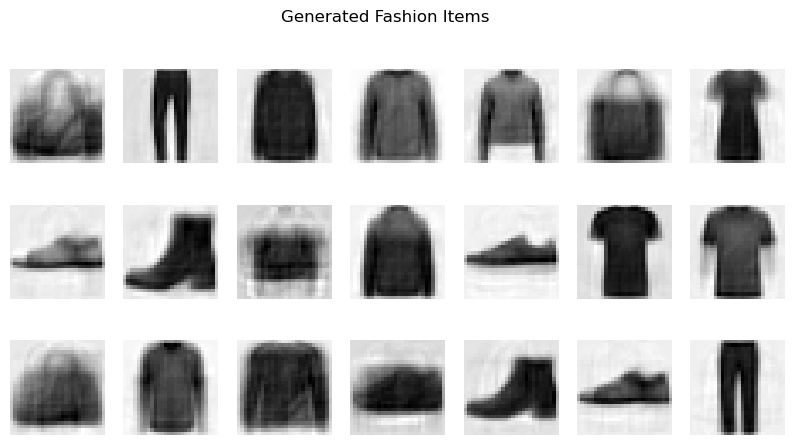

In [ ]:
# Shows some of the fashion items sampled randomly from the generated images

fig,ax = plt.subplots(ROWS, COLUMNS, figsize = (10,5))     # Figure to contain subplots in 5-rows and 9-columns arrangement
ax = ax.ravel()                                 # Flattens the axes allowing accessing each axis contiguously
for i in range(ROWS * COLUMNS):
  ax[i].imshow(images[i], cmap = 'binary')      # Shows the image
  ax[i].axis("off")                             # Set the axis off for being non-relevant in this case

fig.suptitle("Generated Fashion Items")         # Sets title of the figure

## Observations

- Keras function API instead of sequential model approach was used as there was a need for both mean coding and log variance coding layer to recieve the same codings.

- A custom layer was used to sample the coding given mean vector and log variance vector.

- A latent loss function was used to push the codings gradually migrate within the coding space (also called the latent space). It computes the latent loss for each instance in the batch, summing over the last axis.

- During images generation, codings were randomly sampled from a Gaussian distribution, decoded and plotted for visualization.